In [24]:
%load_ext autoreload
#To update the imported files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../')
from constants import *
from utilities_xgb import *
from utilities import *

In [26]:
hyperparameters = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}

# Dataset A

In [27]:
selected_features_a = selected_features.copy()
#selected_features_a.remove("direct_rad:W")
hyperparameters_a = hyperparameters
wanted_months_a = wanted_months

In [28]:
df = subset_months(X_observed_a,wanted_months_a)

In [29]:
df_2 = df[selected_features_a]

In [33]:
X_train_a_prep = prepare_X(X_observed_a, X_estimated_a, selected_features_a, wanted_months_a)
X_train_a, y_train_a = resize_training_data(X_train_a_prep, y_a)
X_test_a_prep = prepare_testdata_rf_a(X_test_a, selected_features_a)

In [34]:
xgb_a = XGB_model(hyperparameters_a, X_train_a, X_test_a_prep, y_train_a)

In [37]:
xgb_a_cross_val_predictions,xgb_a_cross_val_actuals, xgb_a_cross_val_mae_mean = xgb_a.cross_val_stack(X_train_a, y_train_a)

In [39]:
xgb_a.cross_validate(X_train_a, y_train_a)

Cross-validation scores: [299.88924259 293.25184344 301.10671865 281.91490477 158.56470706]
Mean cross-validation score: 266.94548330207533


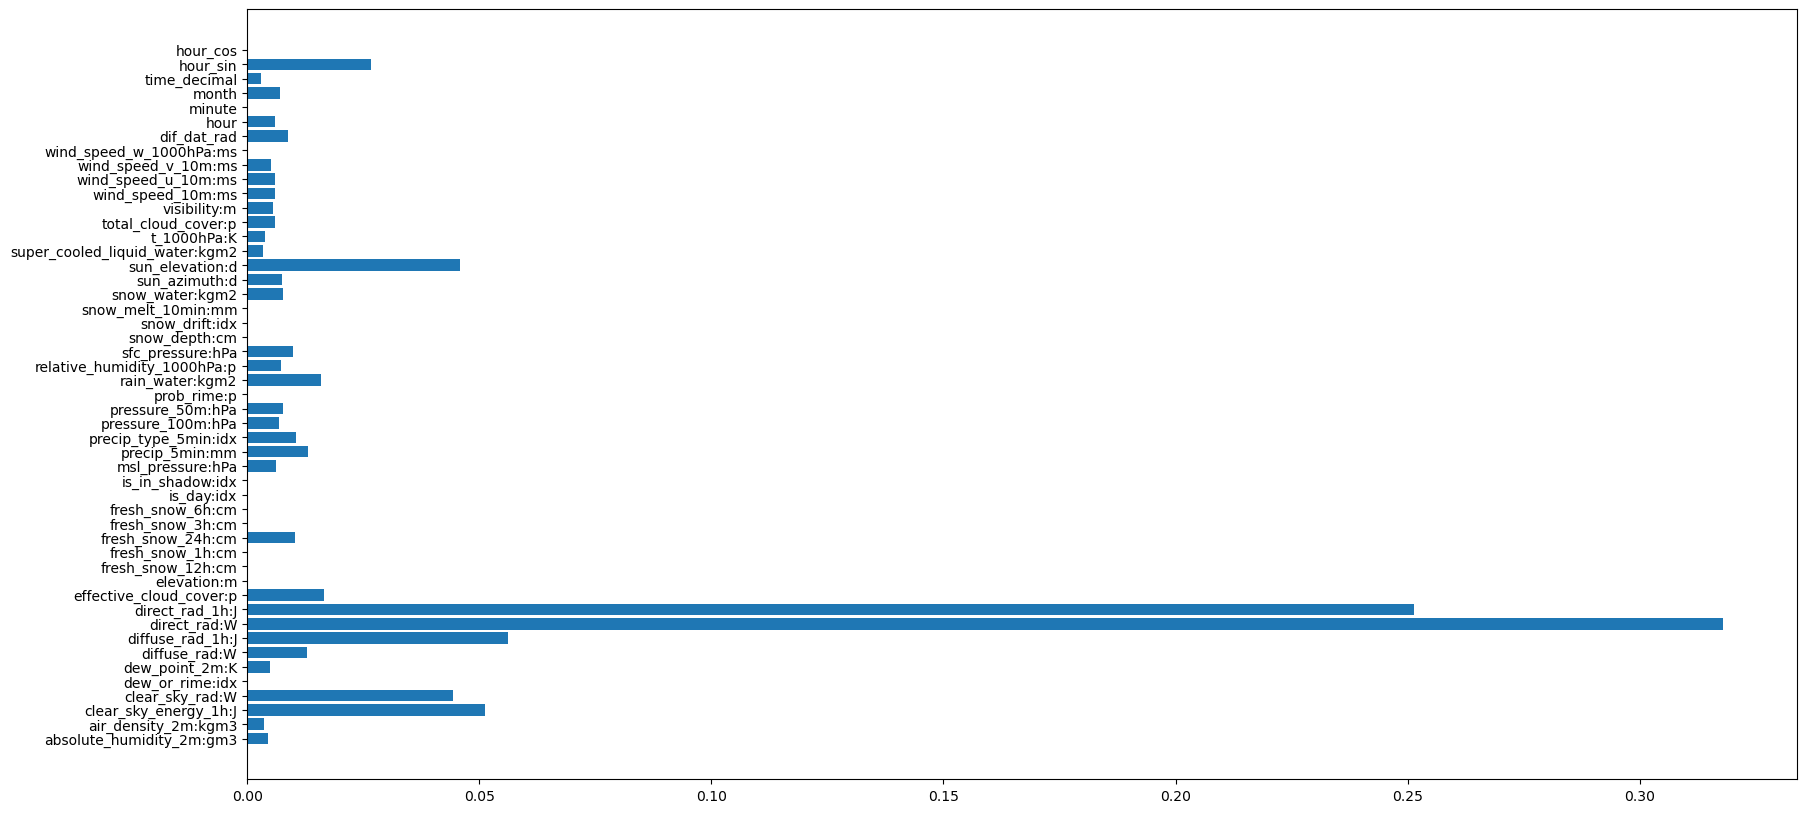

In [11]:
xgb_a.fit()
xgb_a.pred()
xgb_a_test_pred = xgb_a.prediction
xgb_a.feature_importence_plot()

# Dataset B

In [12]:
selected_features_b = selected_features
hyperparameters_b = hyperparameters
wanted_months_b = wanted_months

In [13]:
X_train_b_prep = prepare_X(X_observed_b, X_estimated_b, selected_features_b, wanted_months_b)
X_train_b, y_train_b = resize_training_data(X_train_b_prep, y_b)
X_test_b_prep = prepare_testdata_rf_a(X_test_b, selected_features_b)

In [14]:
xgb_b = XGB_model(hyperparameters_b, X_train_b, X_test_b_prep, y_train_b)

In [15]:
xgb_b_cross_val_predictions,xgb_b_cross_val_actuals, xgb_b_cross_val_mae_mean = xgb_b.cross_val_stack(X_train_b, y_train_b)

In [45]:
xgb_b.cross_validate(X_train_b, y_train_b)

Cross-validation scores: [57.33637274 54.58644499 56.0042985  45.6318334  28.40702539]
Mean cross-validation score: 48.39319500348879


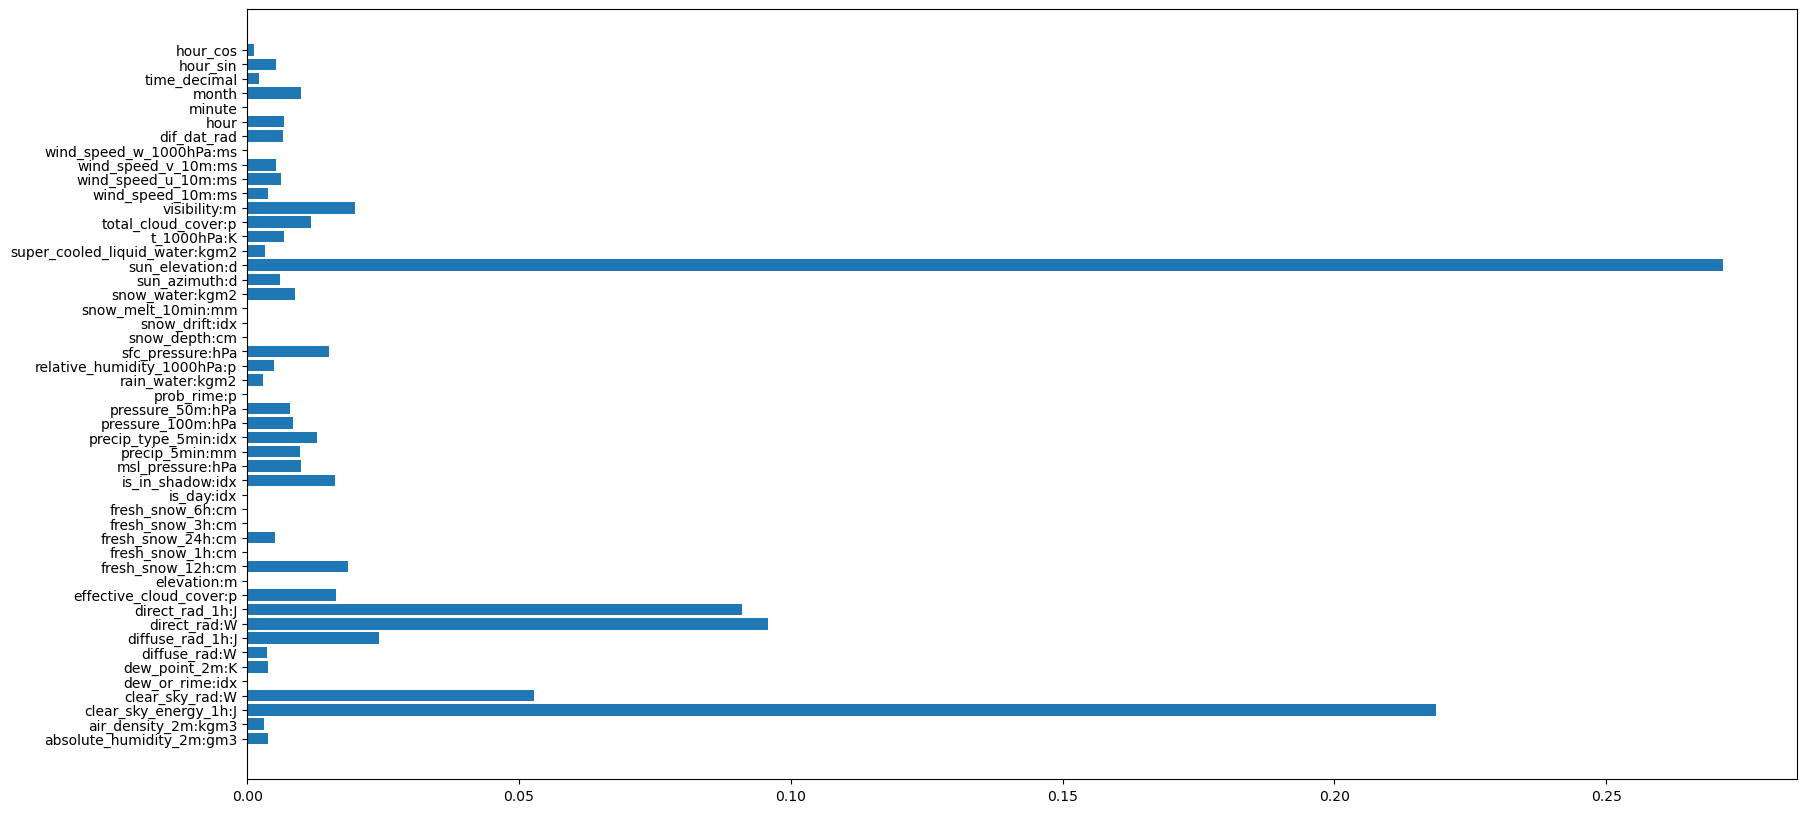

In [17]:
xgb_b.fit()
xgb_b.pred()
xgb_b_test_pred = xgb_b.prediction
xgb_b.feature_importence_plot()

# Dataset C

In [40]:
selected_features_c = selected_features
hyperparameters_c = hyperparameters
wanted_months_c = wanted_months

In [41]:
X_train_c_prep = prepare_X(X_observed_c, X_estimated_c, selected_features_c, wanted_months_c)
X_train_c, y_train_c = resize_training_data(X_train_c_prep, y_c)
X_test_c_prep = prepare_testdata_rf_a(X_test_c, selected_features_c)

In [42]:
xgb_c = XGB_model(hyperparameters_c, X_train_c, X_test_c_prep, y_train_c)

In [43]:
xgb_c_cross_val_predictions,xgb_c_cross_val_actuals, xgb_c_cross_val_mae_mean = xgb_c.cross_val_stack(X_train_c, y_train_c)

In [44]:
#xgb_c.cross_validate(X_train_c, y_train_c)

Cross-validation scores: [32.47530969 47.07872078  6.39121492  7.7175993   7.98278019]
Mean cross-validation score: 20.329124978210512


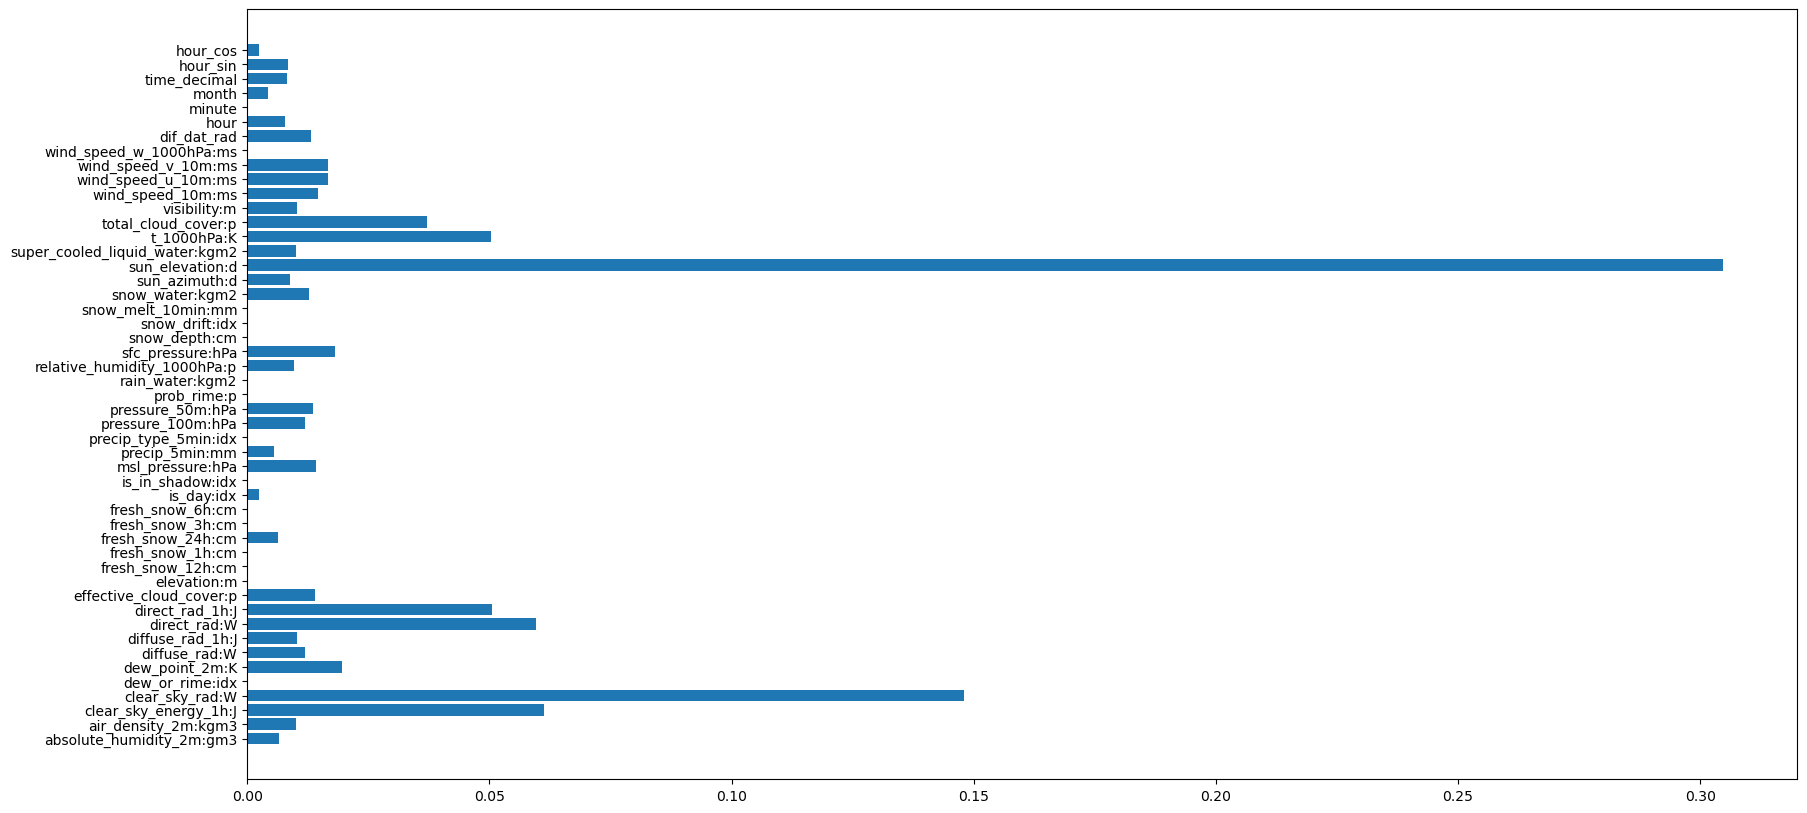

In [23]:
xgb_c.fit()
xgb_c.pred()
xgb_c_test_pred = xgb_c.prediction
xgb_c.feature_importence_plot()